### Reweighting simulation endstates with fancy NN potentials
##### Josh+Marcus+Hannah+dom

In [1]:
import numpy as np
from netCDF4 import Dataset
import os

from simtk import unit, openmm
from openmmtools import integrators
from pymbar import EXP
from openmmtools.constants import kB
temperature = 298 * unit.kelvin
kBT = kB * temperature

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# ANI imports
import torchani
import torch
model = torchani.models.ANI1ccx()

import mdtraj as md

from tqdm import tqdm
import random
import networkx as nx
%matplotlib inline

In [2]:
def compute_ani_energy(element_string, samples):
    # adapted from J.Fass code
    species = model.species_to_tensor(element_string).unsqueeze(0)
    coordinates = torch.tensor([sample * 10 for sample in samples], dtype=torch.float32) # converting nm to Angstrom
    energy = model((torch.stack([species[0]] * len(samples)), coordinates))
    return energy.energies.detach().numpy() * 627.5 #* unit.kilojoule_per_mole # convert from hartree to kJ/mol

def plot_mm_vs_ani(MM, ANI,title='',color='grey'):
    grid = sns.JointGrid(MM,ANI,space=0, height=6, ratio=5)
    grid.plot_joint(sns.scatterplot, color=color, alpha=0.5)
    plt.xlabel(f'MM energies / kJ/mol',weight='semibold')
    plt.ylabel(f'ANI energies / kJ/mol',weight='semibold')
    grid.plot_marginals(sns.kdeplot, shade=True, color=color)
    
    # TODO add much better stats, with error bars
    _, _, r_value, _, _ = scipy.stats.linregress(MM,ANI)

    title = title +r'$R^2$ = '+f'{r_value**2:.2f}'
    ### adding standard deviation labels to marginals
    range_x = (grid.ax_marg_x.dataLim.x0 + grid.ax_marg_x.dataLim.x1)
    mid_x = (range_x)/ 2
    range_y = (grid.ax_marg_y.dataLim.y0 + grid.ax_marg_y.dataLim.y1)
    mid_y = range_y / 2
    grid.ax_marg_x.text(mid_x,grid.ax_marg_x.dataLim.y1*0.2,f'std: {np.std(MM):.1f}',weight='semibold')
    grid.ax_marg_y.text(grid.ax_marg_y.dataLim.x1*0.2,mid_y,f'std: {np.std(ANI):.1f}',weight='semibold')

    #title
    grid.ax_marg_x.text(mid_x,grid.ax_marg_x.dataLim.y1,title,horizontalalignment='center')

    plt.show()

def calculate_correction(MM, ANI,bootstrap=100):
    reduced_works = (MM - ANI) / kBT
    result = EXP(reduced_works)
    return result[0] * kBT, result[1] * kBT 

def show_perturbation(folder):
    # try to open the perturbation image
    try:
        from IPython.display import display, Image
        i = Image(filename=f'/Users/brucemah/bin/nn-endstates/data/jnk1-example/{folder}/render_complex_mapping.png')
        display(i)
    except:
        print('Can\'t open image')

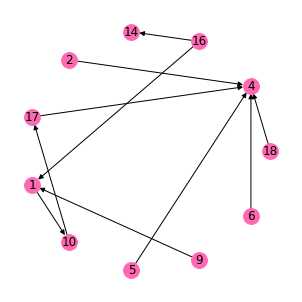

In [3]:
jnk1_ani_edges = [(18, 4), (16, 14), (2, 4), (17, 4), (1, 10), (10, 17), (5, 4), (9, 1), (16, 1), (6, 4)]
G = nx.DiGraph()

for i,j in jnk1_ani_edges:
    G.add_edge(i,j)
    
plt.figure(figsize=(4,4))
nx.draw_circular(G,node_color='hotpink', node_size=250,labels={i:i for i in G.nodes()})
plt.show()

for node in G.nodes():
    # start with empty dict
    G.nodes[node]['results'] = {}

Getting data for edge 18 to 4
Can't open image
No stored positions for edge (18, 4) for ligand 18 for phase complex
No stored positions for edge (18, 4) for ligand 18 for phase solvent
No stored positions for edge (18, 4) for ligand 18 for phase vacuum
No stored positions for edge (18, 4) for ligand 4 for phase complex
No stored positions for edge (18, 4) for ligand 4 for phase solvent
No stored positions for edge (18, 4) for ligand 4 for phase vacuum
Getting data for edge 16 to 14
Can't open image
No stored positions for edge (16, 14) for ligand 16 for phase complex
No stored positions for edge (16, 14) for ligand 16 for phase solvent
No stored positions for edge (16, 14) for ligand 16 for phase vacuum
No stored positions for edge (16, 14) for ligand 14 for phase complex
No stored positions for edge (16, 14) for ligand 14 for phase solvent
No stored positions for edge (16, 14) for ligand 14 for phase vacuum
Getting data for edge 16 to 1


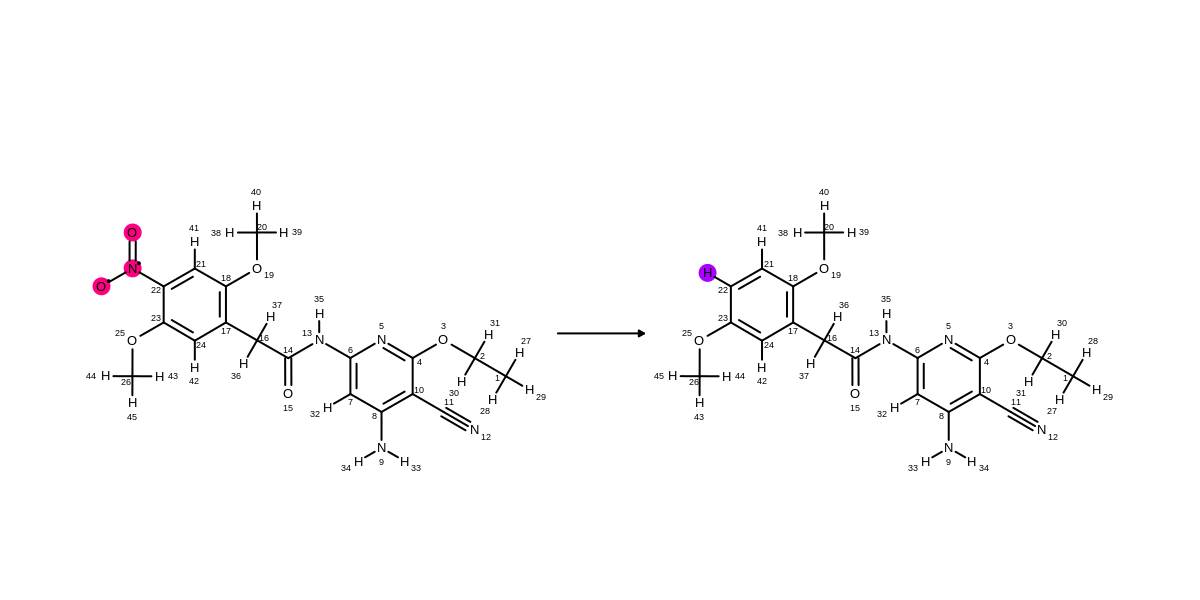

No context for ligand 16 stored yet - loading one from edge (16, 1)
No context for ligand 1 stored yet - loading one from edge (16, 1)
Getting data for edge 2 to 4


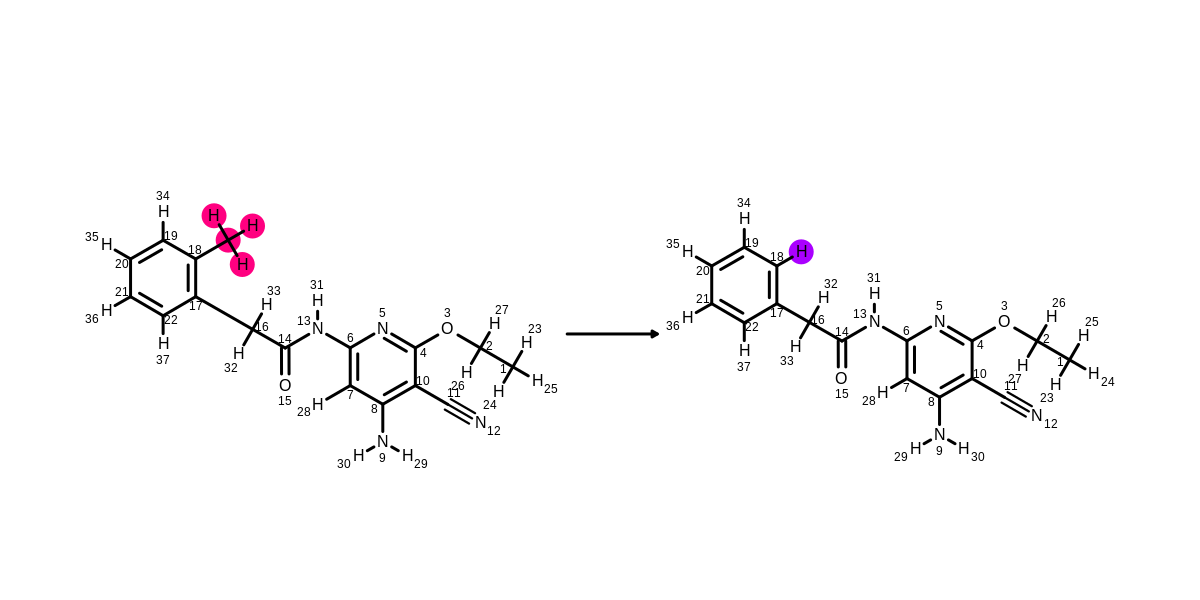

No context for ligand 2 stored yet - loading one from edge (2, 4)
No context for ligand 4 stored yet - loading one from edge (2, 4)
Getting data for edge 17 to 4


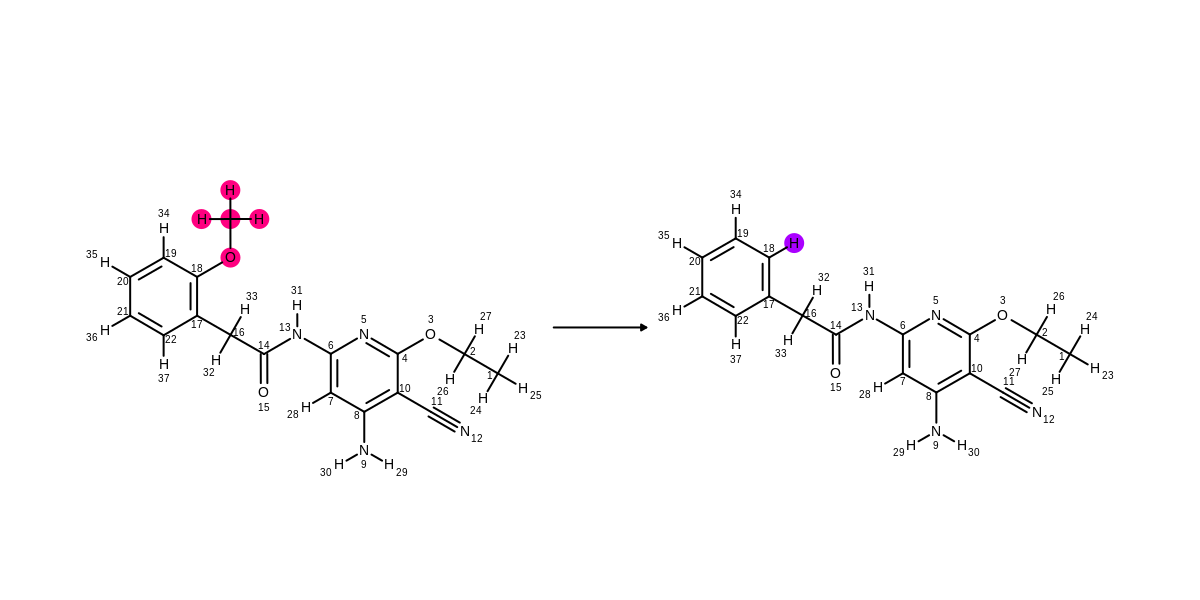

No context for ligand 17 stored yet - loading one from edge (17, 4)
Getting data for edge 1 to 10


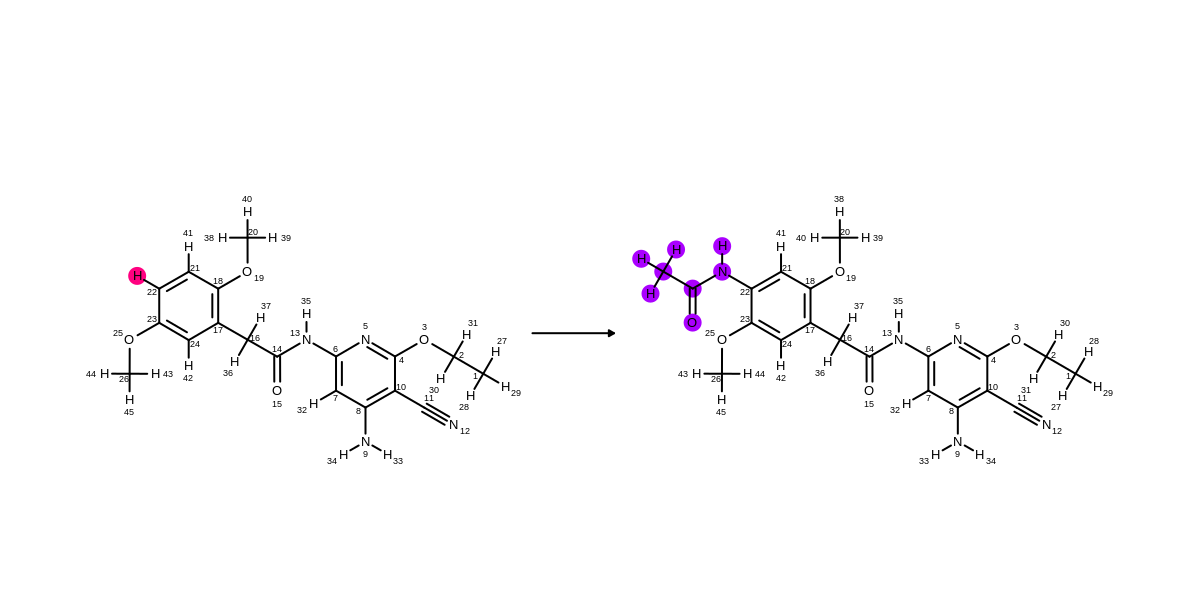

No context for ligand 10 stored yet - loading one from edge (1, 10)
Getting data for edge 10 to 17


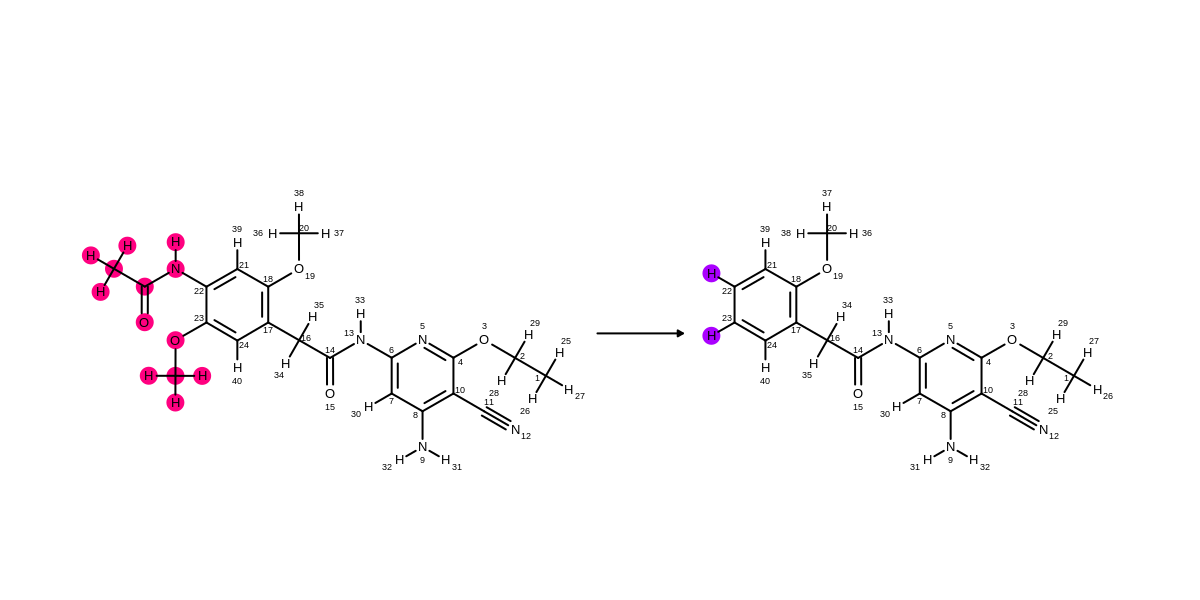

Getting data for edge 5 to 4


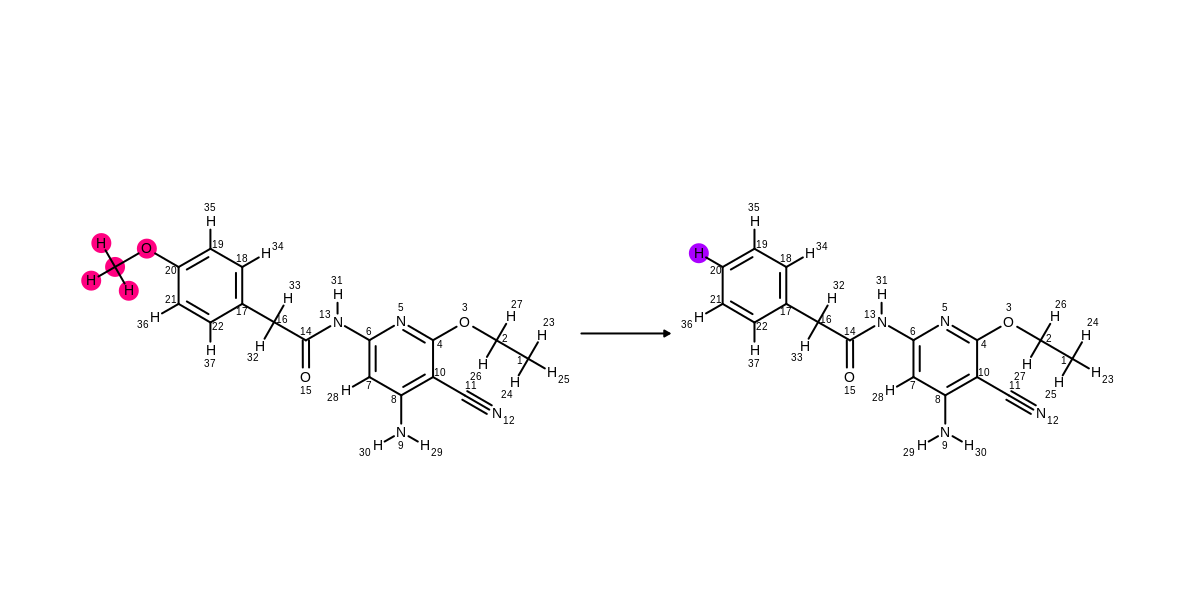

No context for ligand 5 stored yet - loading one from edge (5, 4)
Getting data for edge 9 to 1


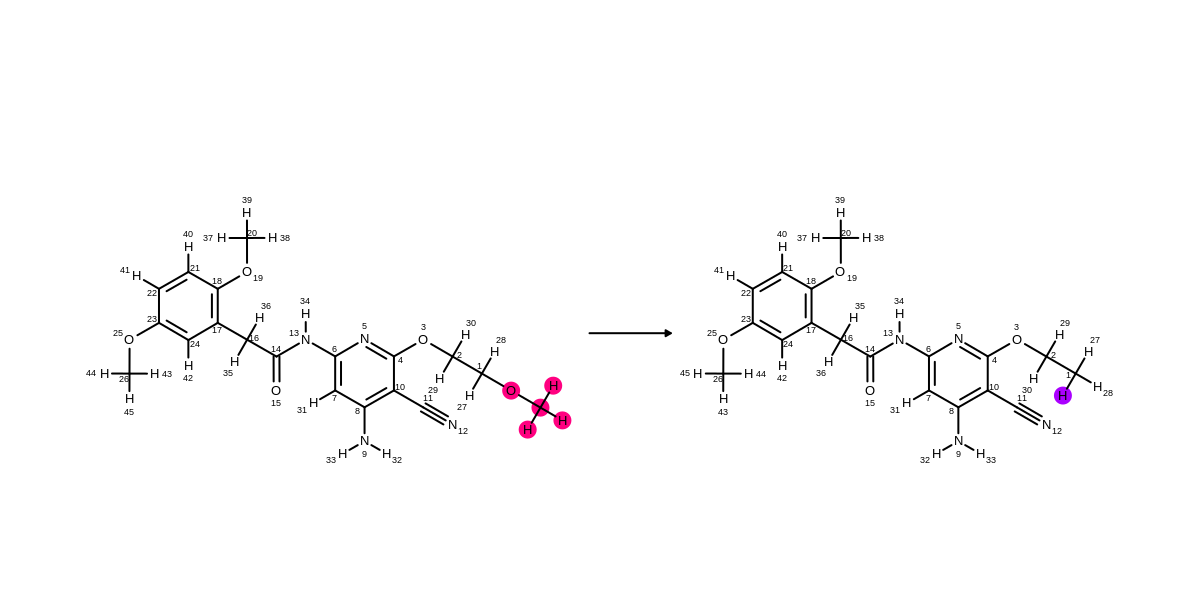

No context for ligand 9 stored yet - loading one from edge (9, 1)
Getting data for edge 6 to 4
Can't open image
No stored positions for edge (6, 4) for ligand 6 for phase complex
No stored positions for edge (6, 4) for ligand 6 for phase solvent
No stored positions for edge (6, 4) for ligand 6 for phase vacuum
No stored positions for edge (6, 4) for ligand 4 for phase complex
No stored positions for edge (6, 4) for ligand 4 for phase solvent
No stored positions for edge (6, 4) for ligand 4 for phase vacuum


In [4]:
phases = ['complex','solvent','vacuum']

for a,b in G.edges():
    print(f'Getting data for edge {a} to {b}')
    folder = f'lig{a}to{b}'
    show_perturbation(folder)

    
    for i in (a,b):
        for phase in phases:
            try:
                positions = np.load(f'data/jnk1-example/{folder}/positions_{str(i)}_{phase}.npy')
            except:
                print(f'No stored positions for edge {a,b} for ligand {i} for phase {phase}')
                continue

            # get the context from the node, or if it's not already got one - load one
            if 'context' not in G.nodes[i].keys():
                print(f'No context for ligand {i} stored yet - loading one from edge {a,b}')
                htf = np.load(f'data/jnk1-example/{folder}/outhybrid_factory.npy',allow_pickle=True)
                htf = htf.flatten()[0]     
                if i == a:
                    context = openmm.Context(htf['vacuum']._old_system, integrators.LangevinIntegrator())
                    element = ''.join([x.element.symbol for i, x in enumerate(htf['vacuum'].hybrid_topology.atoms) if i in htf['vacuum'].old_to_hybrid_atom_map.keys()])
                else:
                    context = openmm.Context(htf['vacuum']._new_system, integrators.LangevinIntegrator())
                    element = ''.join([x.element.symbol for i, x in enumerate(htf['vacuum'].hybrid_topology.atoms) if i in htf['vacuum'].new_to_hybrid_atom_map.keys()])
                G.nodes[i]['context'] = context
                G.nodes[i]['element_str'] = element
            else:
                context = G.nodes[i]['context']
            
            n_iterations, _, _ = np.shape(positions)
            
            MM_results = np.zeros(shape=n_iterations)
            ANI_results = np.zeros(shape=n_iterations)
            
            for j,pos in enumerate(positions):
                # MM energy
                context.setPositions(pos)
                result = context.getState(getEnergy=True).getPotentialEnergy()
                MM_results[j] = result / result.unit
                         
            ANI_results = compute_ani_energy(G.nodes[i]['element_str'], positions)
                
            # STORE THE RESULTS
            G.nodes[i]['results'][f'{folder}_{phase}_MM'] = MM_results
            G.nodes[i]['results'][f'{folder}_{phase}_ANI'] = ANI_results            


LIGAND 18

LIGAND 4
lig17to4
642555.6267679315
642555.6267679315


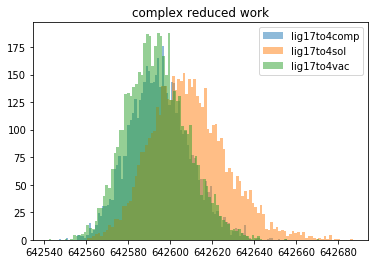

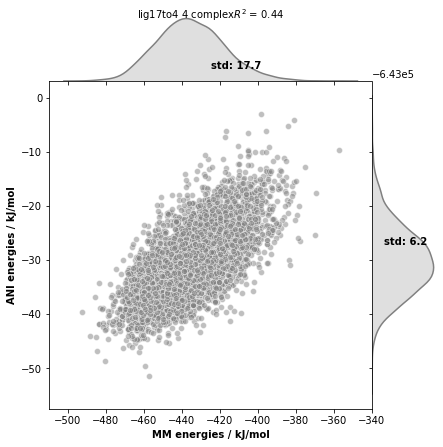

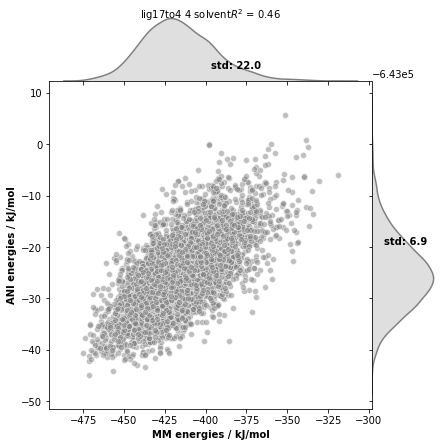

lig2to4
642558.1828052526
642558.1828052526


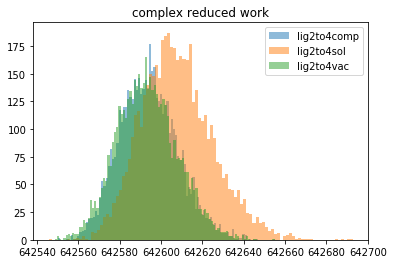

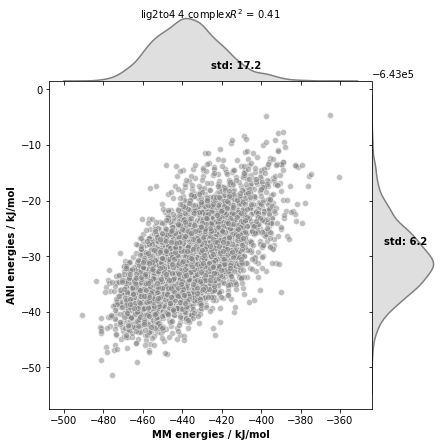

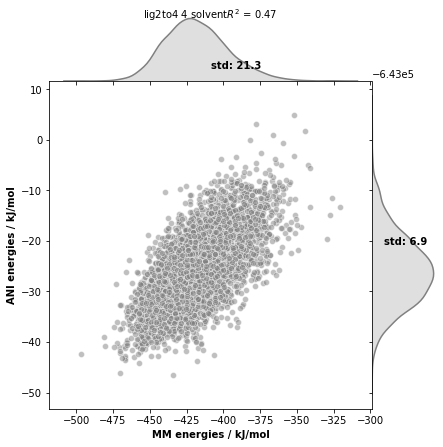

lig5to4
642558.2581704755
642558.2581704755


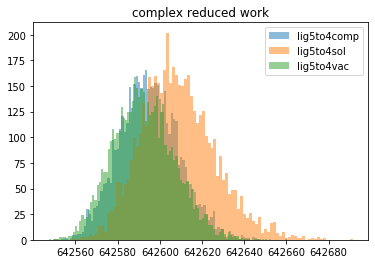

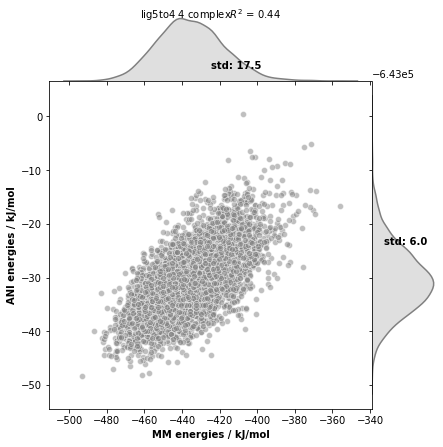

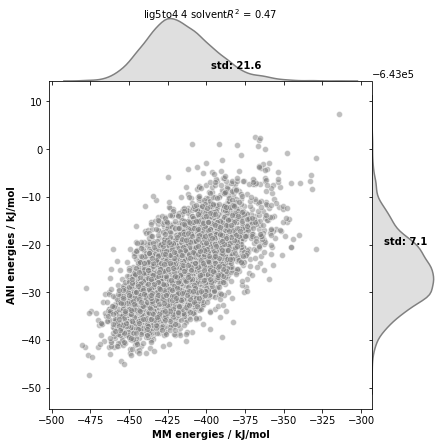


LIGAND 16
lig16to1
891156.8047886598
891156.8047886598


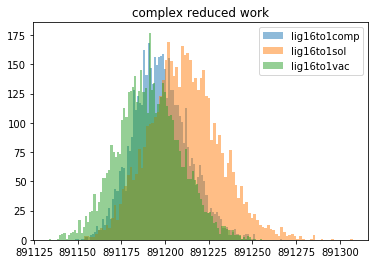

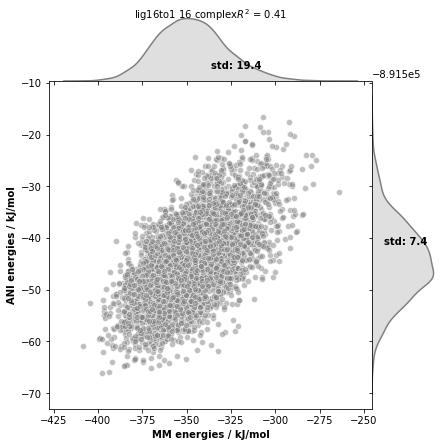

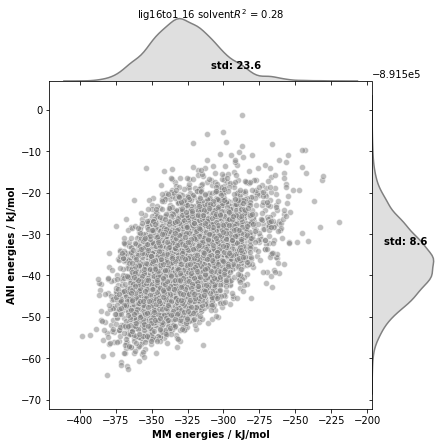


LIGAND 14

LIGAND 2
lig2to4
643910.8982052433
643910.8982052433


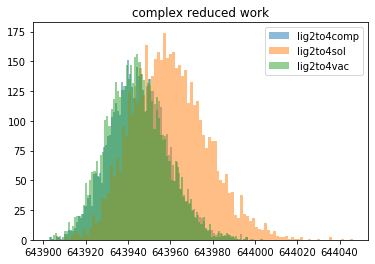

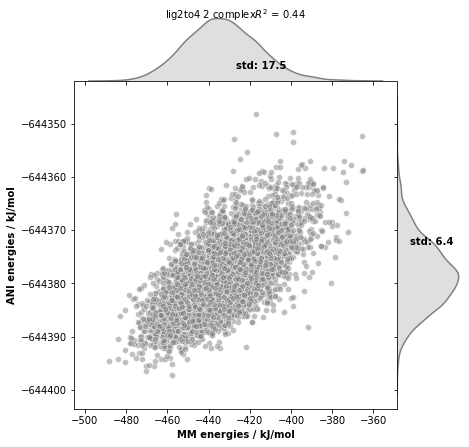

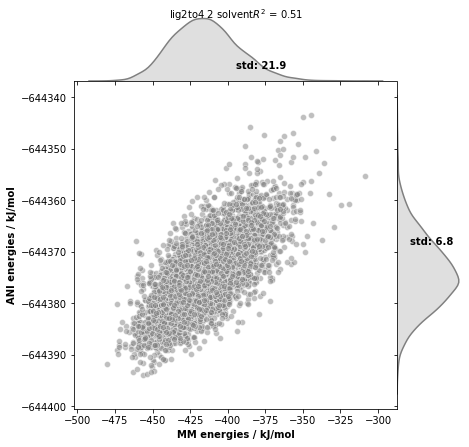


LIGAND 17
lig17to4
691045.9445509093
691045.9445509093


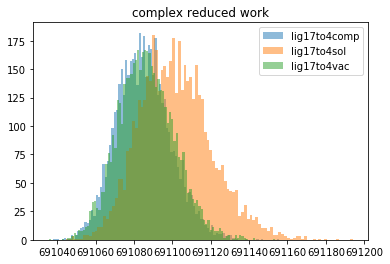

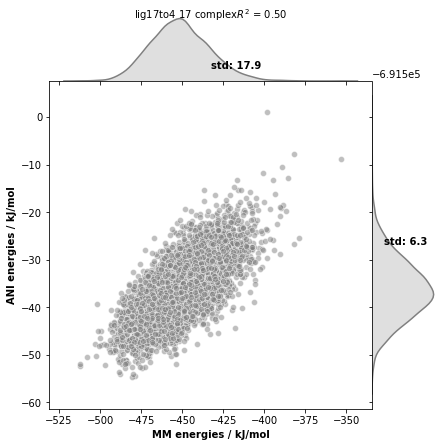

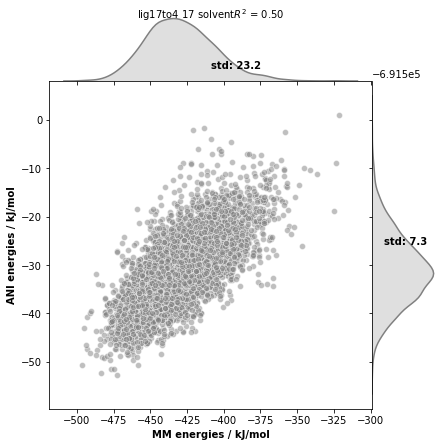

lig10to17
691051.9996258904
691051.9996258904


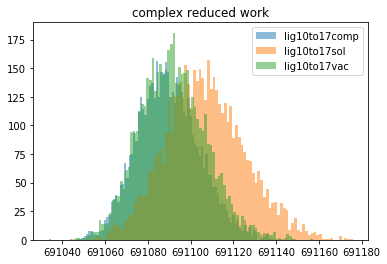

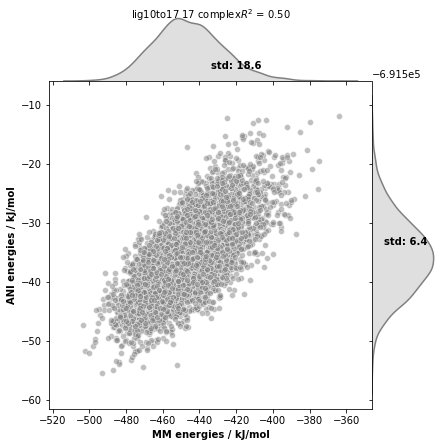

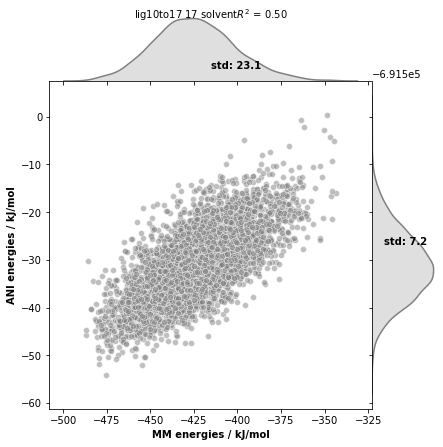


LIGAND 1
lig16to1
889709.2319464937
889709.2319464937


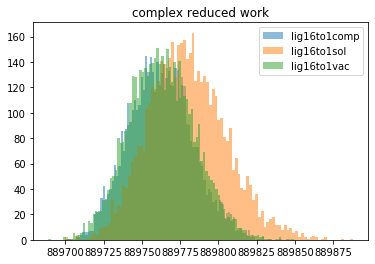

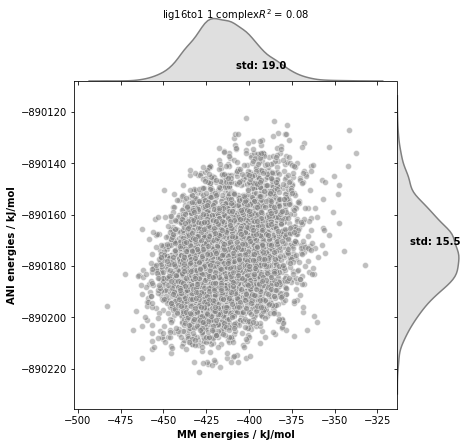

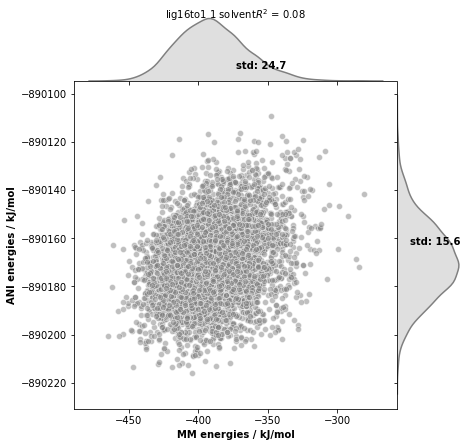

lig1to10
889697.4410798126
889697.4410798126


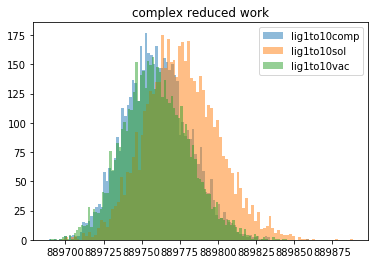

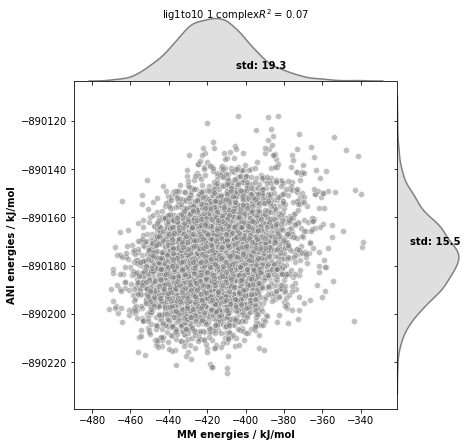

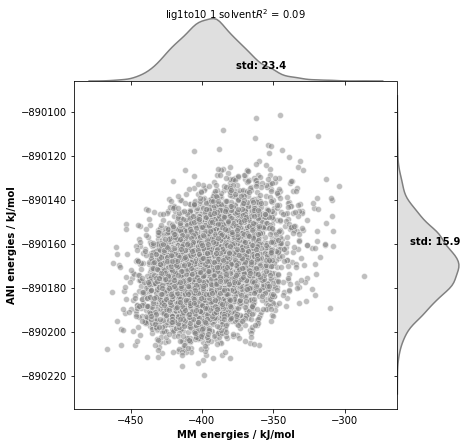

lig9to1
889703.7103596001
889703.7103596001


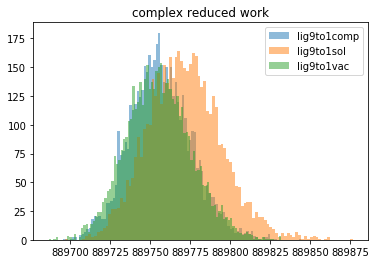

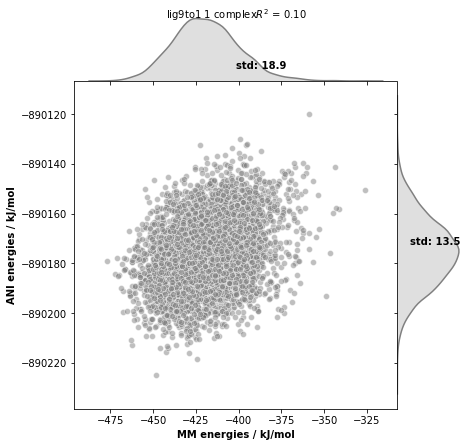

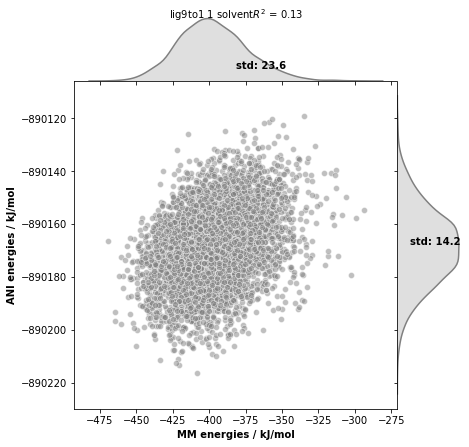


LIGAND 10
lig1to10
868968.3449408766
868968.3449408766


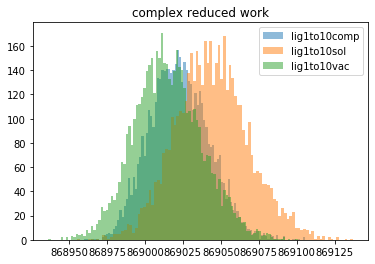

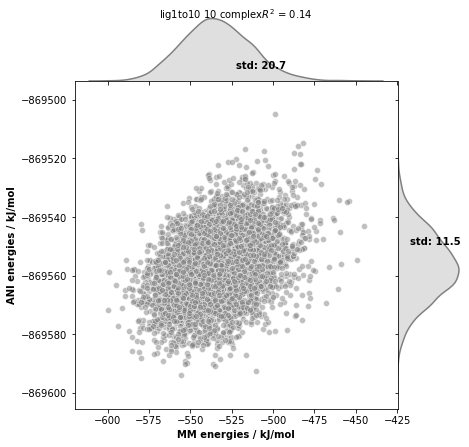

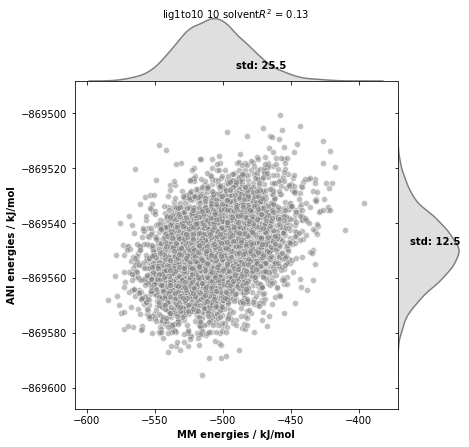

lig10to17
868965.7421849377
868965.7421849377


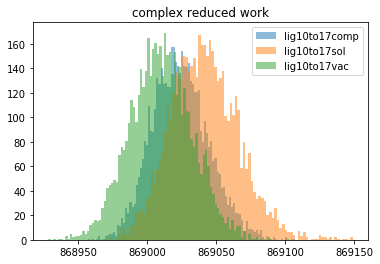

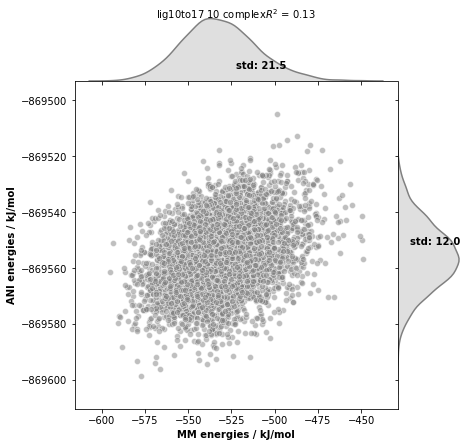

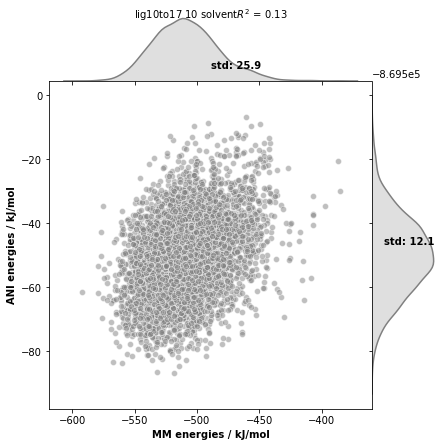


LIGAND 5
lig5to4
691116.7903444365
691116.7903444365


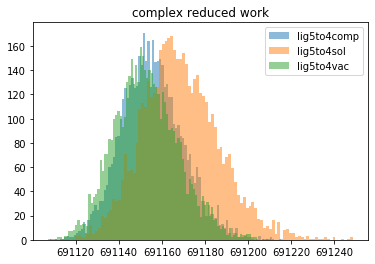

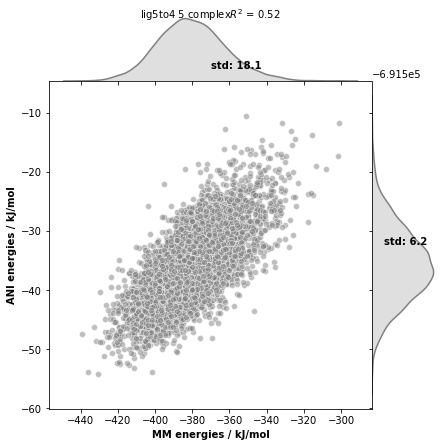

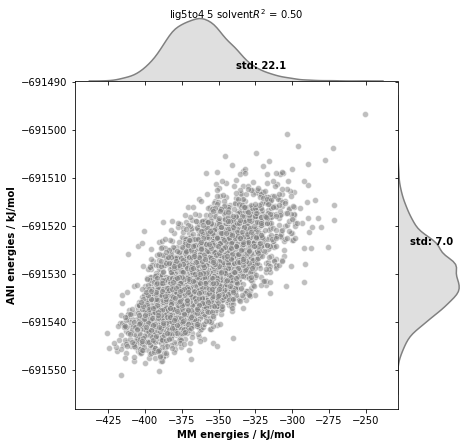


LIGAND 9
lig9to1
834679.0465316572
834679.0465316572


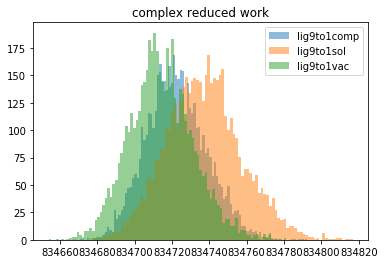

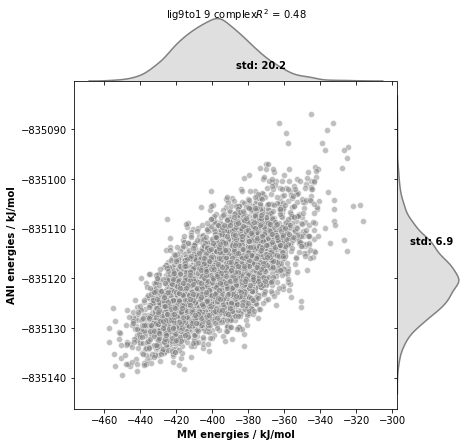

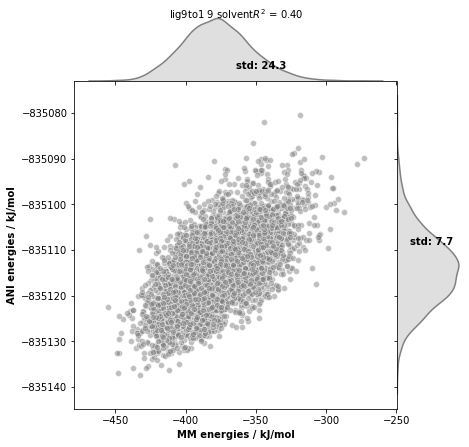


LIGAND 6



In [7]:
import copy

n_bootstrap = 1000

for node in G.nodes(data=True):
    print(f'LIGAND {node[0]}')
    results = copy.deepcopy(node[1]['results']) # change this to deepcopy

    # check the overlap in the energies from different edges
    # stats.f_oneway(data_group1, data_group2, data_group3, data_groupN)

    # shift all the MM results closer to zero
    all_MM_results = [x for x in results.keys() if '_MM' in x]
#         normalise_MM = normalise_energies([results[x] for x in all_MM_results])
#         for x, shifted in zip(all_MM_results, normalise_MM):
#             results[x] = shifted

    # shift all the MM results closer to zero
    all_ANI_results = [x for x in results.keys() if '_ANI' in x]
#         normalise_ANI = normalise_energies([results[x] for x in all_ANI_results])
#         for x, shifted in zip(all_ANI_results, normalise_ANI):
#             results[x] = shifted

    edges = set([x.split('_')[0] for x in results.keys()])
    all_edges_complex_corrections = []
    for edge in edges:
        print(edge)
        complex_reduced_work = results[edge+'_complex_MM'] - results[edge+'_complex_ANI']
        solvent_reduced_work = results[edge+'_solvent_MM'] - results[edge+'_solvent_ANI']
        vacuum_reduced_work = results[edge+'_vacuum_MM'] - results[edge+'_vacuum_ANI']

        complex_corrections = []
        solvent_corrections = []
        vacuum_corrections = []
        for i in range(n_bootstrap):
            complex_correction = EXP(np.random.choice(complex_reduced_work[1:],len(complex_reduced_work)))
            solvent_correction = EXP(np.random.choice(solvent_reduced_work[1:],len(complex_reduced_work)))
            vacuum_correction = EXP(np.random.choice(solvent_reduced_work[1:],len(complex_reduced_work)))
            complex_corrections.append(complex_correction[0])
            solvent_corrections.append(solvent_correction[0])

#                 print(f'CORRECTION = {(complex_correction[0] - solvent_correction[0]) * unit.kilocalorie_per_mole}')
#                 print(f'ERROR: {(complex_correction[1]**2 + solvent_correction[1]**2)**0.5 * unit.kilocalorie_per_mole}')
#                 print()

        all_edges_complex_corrections.append(complex_corrections)
        plt.title('complex reduced work')
        plt.hist(complex_reduced_work[1:],bins=100, label=f'{edge}comp',alpha=0.5)
        plt.hist(solvent_reduced_work[1:],bins=100, label=f'{edge}sol',alpha=0.5)
        plt.hist(vacuum_reduced_work[1:],bins=100, label=f'{edge}vac',alpha=0.5)
        plt.legend()
        print(EXP(complex_reduced_work[1:])[0])
        print(EXP(complex_reduced_work[1:])[0])
#             plt.show()
#             plt.hist(results[edge+'_complex_MM'],label='complex MM',bins=100)
# #             plt.hist(results[edge+'_solvent_MM'],label='solvent MM',bins=100)
# #             plt.legend()
# #             plt.title(edge)
# #             plt.show()

#             plt.hist(results[edge+'_complex_ANI'],label='complex ANI',bins=100)
# #             plt.hist(results[edge+'_solvent_ANI'],label='solvent ANI',bins=100)
#             plt.legend()
#             plt.title(edge)
#             plt.show()

        plot_mm_vs_ani(results[edge+'_complex_MM'][1:],results[edge+'_complex_ANI'][1:],title=f'{edge} {node[0]} complex')
        plot_mm_vs_ani(results[edge+'_solvent_MM'][1:],results[edge+'_solvent_ANI'][1:],title=f'{edge} {node[0]} solvent')
    plt.show()
    print()


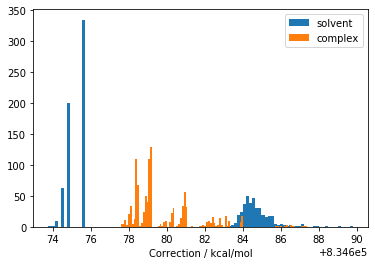

In [8]:
plt.hist(solvent_corrections,bins=100,label='solvent')
plt.hist(complex_corrections,bins=100,label='complex')
plt.xlabel(f'Correction / kcal/mol')
plt.legend()
plt.show()

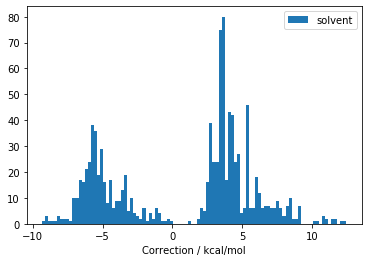

In [9]:
plt.hist([i-j for i,j in zip(complex_corrections,solvent_corrections)],bins=100,label='solvent')
# plt.hist(complex_corrections,bins=100,label='complex')
plt.xlabel(f'Correction / kcal/mol')
plt.legend()
plt.show()

In [35]:
F = nx.DiGraph()

for node in G.nodes(data=True):
    # leave behind the context
    F.add_node(node[0],**{x:node[1][x] for x in node[1].keys() if x != 'context'})
    
for edge in G.edges(data=True):
    F.add_edge(edge[0],edge[1])

In [36]:
import pickle
with open('TheBeast.pi', 'wb') as f:
    pickle.dump(F, f)

In [ ]:
# TODO - closer to experiment or not?

In [ ]:
# TODO check if the correction is the same for each edge of the same node (it should be)